<h2>Importando as bibliotecas necessárias


In [2]:
import requests as rq
import pandas as pd
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<h2>Criando o dataframe das planilhas hospedadas no github

In [3]:
url = "https://github.com/kairobeduti/DadosShift/blob/master/Header/Api_Header.xlsx?raw=true"
data = rq.get(url).content
df_header = pd.read_excel(BytesIO(data))
df_header.drop('Unnamed: 0', axis='columns',inplace=True)

In [4]:
url = "https://github.com/kairobeduti/DadosShift/blob/master/Principal/Async_Api_Principal.xlsx?raw=true"
data = rq.get(url).content
df = pd.read_excel(BytesIO(data))
df.drop(['DESC_OBJ_CONTRAT','Unnamed: 0','ANEXOS','ITEMS'], axis='columns',inplace=True)

In [5]:

url = "https://github.com/kairobeduti/DadosShift/blob/master/Dispute_Mode.xlsx?raw=true"
data = rq.get(url).content
df_dispute_mode = pd.read_excel(BytesIO(data))
df_dispute_mode.set_axis(['DISPUTE_MODE','DISPUTE_MODE_D'],axis=1,inplace=True)

In [6]:

url = "https://github.com/kairobeduti/DadosShift/blob/master/Sub_Status.xlsx?raw=true"
data = rq.get(url).content
df_sub_status = pd.read_excel(BytesIO(data))

In [7]:

url = "https://github.com/kairobeduti/DadosShift/blob/master/Hist%C3%B3rico/Historico_RELEVANT_DATES.xlsx?raw=true"
data = rq.get(url).content
df_relevant_dates = pd.read_excel(BytesIO(data))
df_relevant_dates.drop(['Unnamed: 0','PUBL_DATE'], axis='columns',inplace=True)

<h2>Conhecendo algumas informações dos dataframes

In [8]:
print(f'principal {df.shape}')
print(f'header {df_header.shape}')
print(f'dispute mode {df_dispute_mode.shape}')
print(f'sub status {df_sub_status.shape}')
print(f'relevant dates {df_relevant_dates.shape}')

principal (9952, 29)
header (45917, 32)
dispute mode (4, 2)
sub status (4, 2)
relevant dates (9892, 9)


In [9]:
#Header
# df.head().to_excel('df_head().xlsx')
# df_header.head().to_excel('df_header_head().xlsx')
# df_relevant_dates.head().to_excel('df_relevant_dates_head().xlsx')
# df_dispute_mode.head().to_excel('df_df_dispute_mode_head().xlsx')
# df_sub_status.head().to_excel('df_sub_status_head().xlsx')

<h2> Juntando os dataframes

In [10]:
df = df.merge(df_dispute_mode,on='DISPUTE_MODE')
df = df.merge(df_sub_status,on='SUB_STATUS')
df = df.merge(df_header,on='OPPORT_NUM')
df = df.merge(df_relevant_dates,on='OPPORT_NUM')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45994 entries, 0 to 45993
Data columns (total 70 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OPPORT_NUM                 45994 non-null  int64  
 1   DOU_NUM                    0 non-null      float64
 2   LIMIT_IN_DAYS              45994 non-null  int64  
 3   COMPANY                    45994 non-null  int64  
 4   COMPANY_DESC               45994 non-null  object 
 5   STATUS                     31921 non-null  object 
 6   STATUS_DESC                31921 non-null  object 
 7   OPPORT_TYPE                45994 non-null  object 
 8   POSTING_DATE               45994 non-null  object 
 9   OPPORT_DESCR               45992 non-null  object 
 10  DOU_PUBL_DATE              45994 non-null  object 
 11  START_DATE_x               45994 non-null  object 
 12  START_HOUR                 45994 non-null  object 
 13  END_DATE_x                 45994 non-null  obj

<h2>Faz um loop nas colunas para entender qual tem valores distintos e remove

In [11]:
checa=df[df['OPPORT_NUM']==7002573241]
colunas_duplicadas = []

for t in checa.columns.to_list():
    if len(checa[t].unique()) >1:
        colunas_duplicadas.append(t)
df.drop(colunas_duplicadas,axis='columns',inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True,inplace=True)

<h2>Dropa as colunas que estejam 100% vazias

In [12]:
#dropar colunas vazias
#how=all, dropa somente quando a coluna inteira está vazia
df.dropna(axis='columns',how='all',inplace=True)

<h2>Analisando numero de registros por oportunidade</br>
Aparentemente está com registros duplicados baseado em alguma coluna

In [13]:
df['OPPORT_NUM'].value_counts().to_frame().sort_values('OPPORT_NUM',ascending=False)

,OPPORT_NUM
7001983403,1
7001984725,1
7002080117,1
7001988280,1
7001993452,1
...,...
7003401905,1
7003406123,1
7003386768,1
7003429649,1


<h2> Dropar as colunas que possuem o mesmo valor de cima em baixo

In [14]:
#dropar colunas que tem somente 1 registro para todo o dataset
lista_colunas = df.columns.to_list()
lista_valor_unico_remover = []
for row in lista_colunas:
  if len(df[row].unique()) == 1:
    lista_valor_unico_remover.append(row)
print(lista_valor_unico_remover)
df.drop(columns=lista_valor_unico_remover,inplace=True)

['LIMIT_IN_DAYS', 'COMPANY', 'COMPANY_DESC', 'POSTING_DATE', 'OPEN_DATE', 'OPEN_HOUR', 'PQ_VENDOR_LIST_DATE', 'PQ_VENDOR_LIST_HOUR', 'REGIONS', 'CO_CODE', 'EMP_DESCRIPTION']


<h2> checando colunas com sufixo _x e _y. Essas colunas são criadas automaticamente pelo pandas quando no merge elas tem o mesmo nome </br>
Abaixo são verificadas essas colunas, comparados os dados de ambas e se fore realmente identicas, deixa somente uma delas

In [15]:
lista_colunas = df.columns.to_list()
cols_duplicadas = []
for cols in lista_colunas:
     if '_x' in cols or '_y' in cols:
         cols_duplicadas.append(cols.replace('_x','').replace('_y',''))
dict_colunas_repetidas = {}
for  cols_dpl in set(sorted(cols_duplicadas)):
    set_comparacao = set((df[cols_dpl+'_y'] == df[cols_dpl+'_x']).to_list())
    if len(set_comparacao) == 1 and list(set_comparacao)[0]:
        print(cols_dpl, '  ', set_comparacao)
        df[cols_dpl] = df[cols_dpl+'_x']
        print([cols_dpl+'_y',cols_dpl+'_x'])
        df.drop([cols_dpl+'_y',cols_dpl+'_x'], axis='columns',inplace=True)

DISPUTE_MODE    {True}
['DISPUTE_MODE_y', 'DISPUTE_MODE_x']
AUC_START_DATE    {True}
['AUC_START_DATE_y', 'AUC_START_DATE_x']
AUC_START_TIME    {True}
['AUC_START_TIME_y', 'AUC_START_TIME_x']
END_DATE    {True}
['END_DATE_y', 'END_DATE_x']
START_DATE    {True}
['START_DATE_y', 'START_DATE_x']


<h2> Preenche todos os registros que estejam nulos com a instrução "SEM |Nome da coluna|"

In [16]:
lista_colunas = df.columns.to_list()
for lst_cols in lista_colunas:
    if df[lst_cols].value_counts().sum() != df.shape[0]:
        df[lst_cols].fillna('SEM '+lst_cols,inplace=True)

<h2> Checando as colunas de data para fazer o parse datetime

In [17]:
import ast

for ix,dvl in df.iterrows():
    l_dvl = ast.literal_eval(dvl['DIVULG_DATE'])
    if len(l_dvl) == 1:
        dic_pbl = l_dvl[0]
        for dct in dic_pbl:
            df.loc[df.index[ix], 'DIVULG_DATE_'+dct] = dic_pbl[dct]

df['DIVULG_DATE_YPCON_DATE'] = df['DIVULG_DATE_YPCON_DATE'].apply(lambda x: '1900-01-01' if x == '0000-00-00' else x )
df['DIVULG_DATE_YPCON_DATE_H'] = pd.to_datetime(df['DIVULG_DATE_YPCON_DATE'] + ' ' +df['DIVULG_DATE_YPCON_TIME'])
df.drop(columns=['DIVULG_DATE_YPCON_DATE','DIVULG_DATE','DIVULG_DATE_YPCON_TIME'],inplace=True)

In [18]:
#juntar start date + start hour
df['START_DATE'] = df['START_DATE'].apply(lambda x: '1900-01-01' if x == '0000-00-00' else x )
df['START_DATE_H'] = pd.to_datetime(df['START_DATE'] + ' ' +df['START_HOUR'])
df.drop(columns=['START_DATE'],inplace=True)
df.drop(columns=['START_HOUR'],inplace=True)
df.drop(columns=['START_TIME_x'],inplace=True)
df.drop(columns=['START_TIME_y'],inplace=True)

In [19]:
#juntar start date + start hour
df['QUOT_DEAD'] = df['QUOT_DEAD'].apply(lambda x: '1900-01-01' if x == '0000-00-00' else x )
df['QUOT_DEAD_H'] = pd.to_datetime(df['QUOT_DEAD'] + ' ' +df['QUOT_DEAD_TIME'])
df.drop(columns=['QUOT_DEAD'],inplace=True)
df.drop(columns=['QUOT_DEAD_TIME'],inplace=True)

In [20]:
#juntar end date + end hour
df['CREATED_AT_DATE'] = df['CREATED_AT_DATE'].apply(lambda x: '1900-01-01' if x == '0000-00-00' else x )
df['CREATED_AT_DATE_H'] = pd.to_datetime(df['CREATED_AT_DATE'] + ' ' +df['CREATED_AT_TIME'])
df.drop(columns=['CREATED_AT_DATE'],inplace=True)
df.drop(columns=['CREATED_AT_TIME'],inplace=True)

In [21]:
#juntar auc date + auchour
df['END_DATE'] = df['END_DATE'].apply(lambda x: '1900-01-01' if x == '0000-00-00' else x )
df['END_DATE_H'] = pd.to_datetime(df['END_DATE'] + ' ' +df['END_HOUR'])
df.drop(columns=['END_DATE'],inplace=True)
df.drop(columns=['END_HOUR'],inplace=True)
df.drop(columns=['END_TIME'],inplace=True)

In [22]:
#juntar auc date + auchour
df['AUC_START_DATE'] = df['AUC_START_DATE'].apply(lambda x: '1900-01-01' if x == '0000-00-00' else x )
df['AUC_START_DATE_H'] = pd.to_datetime(df['AUC_START_DATE'] + ' ' +df['AUC_START_TIME'])
df.drop(columns=['AUC_START_DATE'],inplace=True)
df.drop(columns=['AUC_START_TIME'],inplace=True)

In [23]:
#juntar auc date + auchour
df['COMMERCIAL_PROP_OPEN_DATE'] = df['COMMERCIAL_PROP_OPEN_DATE'].apply(lambda x: '1900-01-01' if x == '0000-00-00' else x )
df['COMMERCIAL_PROP_OPEN_DATE_H'] = pd.to_datetime(df['COMMERCIAL_PROP_OPEN_DATE'] + ' ' +df['COMMERCIAL_PROP_OPEN_TIME'])
df.drop(columns=['COMMERCIAL_PROP_OPEN_DATE'],inplace=True)
df.drop(columns=['COMMERCIAL_PROP_OPEN_TIME'],inplace=True)

In [24]:
print(set((df['DOU_PUBL_DATE'] == df['PUBL_DOU_DATE']).to_list()))

{False, True}


In [25]:
#juntar auc date + auchour
df['DOU_PUBL_DATE'] = pd.to_datetime(df['DOU_PUBL_DATE'].apply(lambda x: '1900-01-01' if x == '0000-00-00' else x ))
df['PUBL_DOU_DATE'] = pd.to_datetime(df['PUBL_DOU_DATE'].apply(lambda x: '1900-01-01' if x == '0000-00-00' else x ))
df['RECURSAL_PERIOD'] = pd.to_datetime(df['RECURSAL_PERIOD'].apply(lambda x: '1900-01-01' if x == '0000-00-00' else x ))

In [26]:
df['STATUS'] =  df['STATUS']+' - '+ df['STATUS_DESC']
df.drop('STATUS_DESC',axis='columns',inplace=True)

<h2> Criando uma lista com colunas do tipo object para usar na função de plot

In [27]:
df_colunas_obj = df.loc[:, df.dtypes == object]
cols_object = df_colunas_obj.describe().T
cols_object = cols_object.reset_index()
cols_object['dist_uniques'] = (cols_object['unique'] / cols_object['count'])*100
cols_object = cols_object[cols_object['dist_uniques']<80]
lista_objects = cols_object['index'].to_list()

In [28]:
df_colunas_int = df.loc[:, df.dtypes == np.int64]
df_colunas_int

,OPPORT_NUM,SUB_STATUS,YPCON_QUOTE_REQUEST,DISPUTE_MODE
0,7001983403,1,3,2
1,7002002456,1,3,2
2,7001993452,1,3,2
3,7001982249,1,3,2
4,7001982251,1,3,2
...,...,...,...,...
9191,7003380584,3,3,1
9192,7003444066,3,3,1
9193,7003523176,3,2,1
9194,7003534685,3,2,1


15


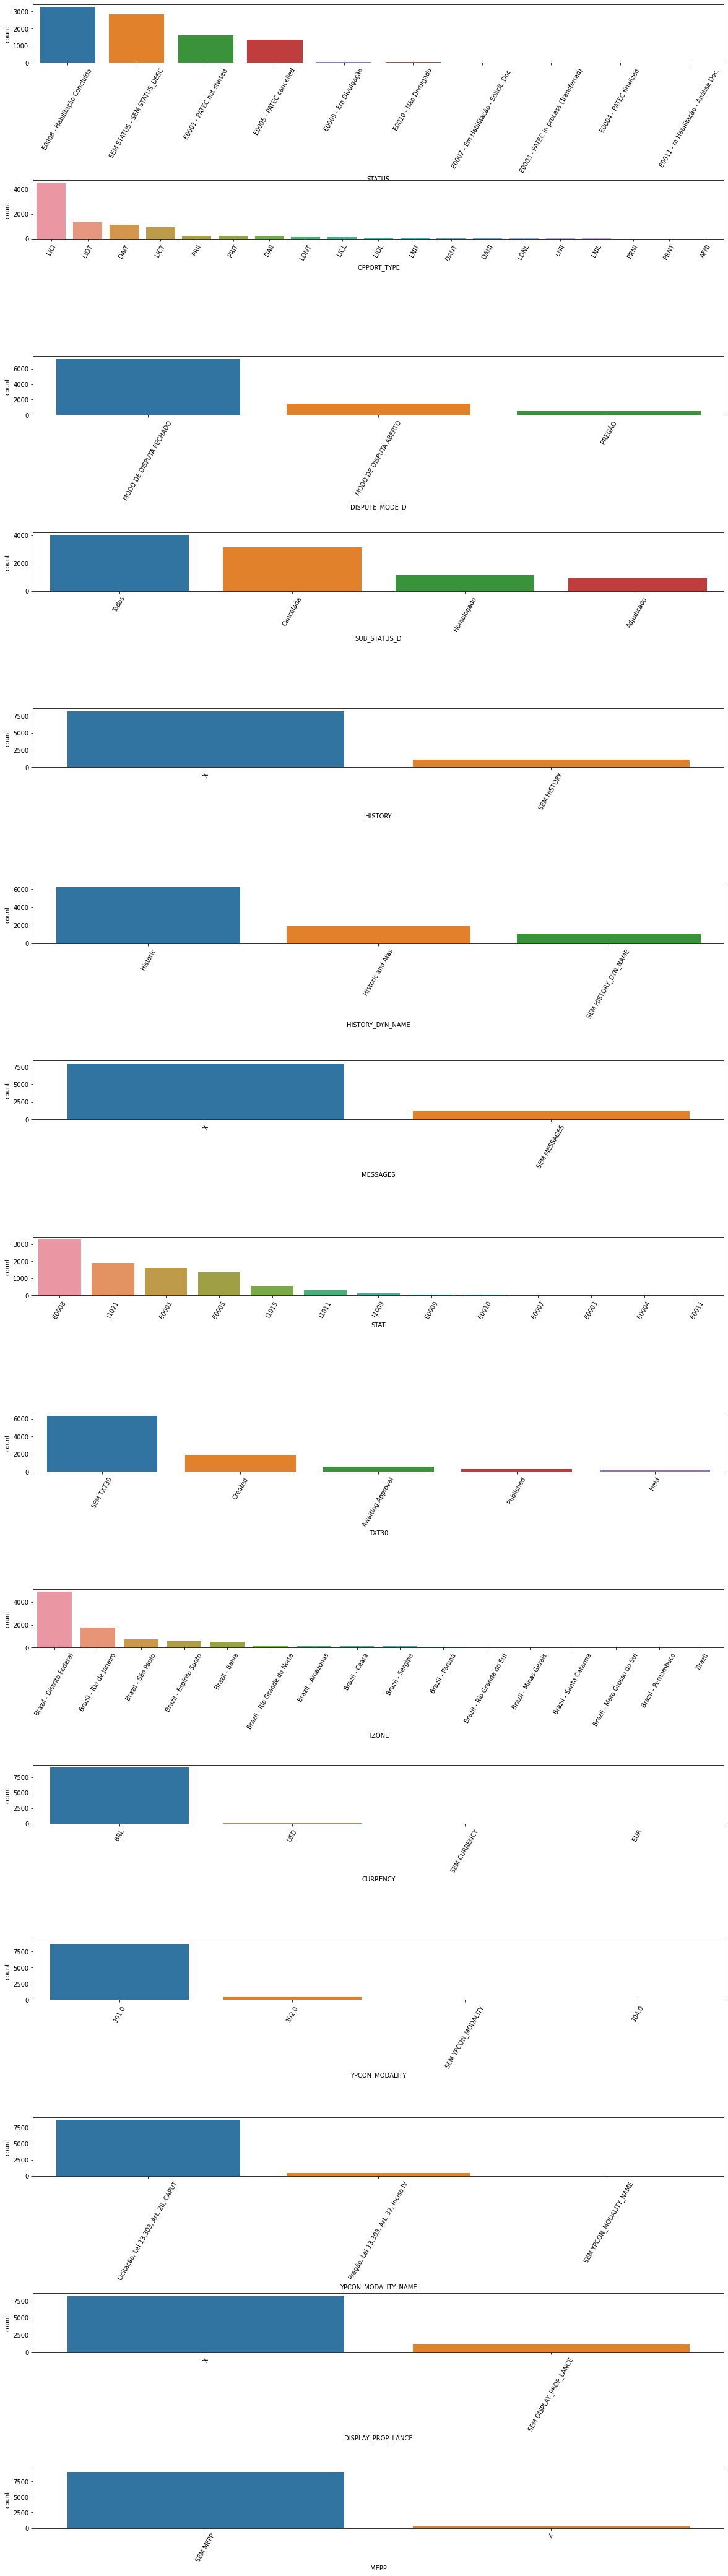

In [29]:
qtdplots = len(lista_objects)

if qtdplots==1:
  f, ax = plt.subplots(figsize=(30,20))
  sns.countplot(x=lista_objects[0], data=df, order=df[lista_objects[0]].value_counts().index)
else:

  print(qtdplots)
  f, ax = plt.subplots(qtdplots,1,figsize=(20,qtdplots*5))
  # Adjust the subplot layout parameters
  f.subplots_adjust(hspace=2, wspace=0.125)
  for idx,plts in enumerate(lista_objects):
    #print(plts)
    ax[idx]=sns.countplot(ax=ax[idx],x=plts, data=df, order=df[plts].value_counts().index)
    ax[idx].tick_params(axis='x', rotation=60)


##IMPLEMENTAR O LOOP PARA QUNADO ENCONTRA MAIS DE UM OBJECT

<h2> plota alguns countplots para numéricos

<AxesSubplot:xlabel='YPCON_QUOTE_REQUEST', ylabel='count'>

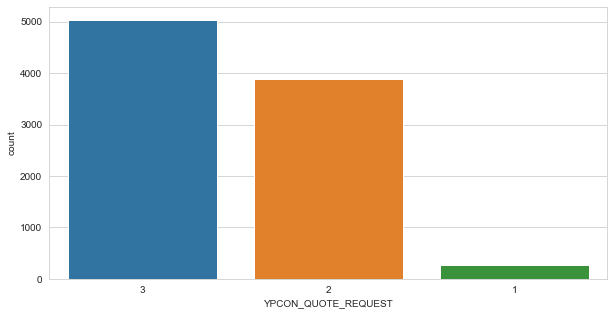

In [30]:
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(10,5))
sns.countplot(x='YPCON_QUOTE_REQUEST', data=df, order=df['YPCON_QUOTE_REQUEST'].value_counts().index)

In [31]:
df['END_DATE_H_MES'] = df['END_DATE_H'].dt.to_period('M')

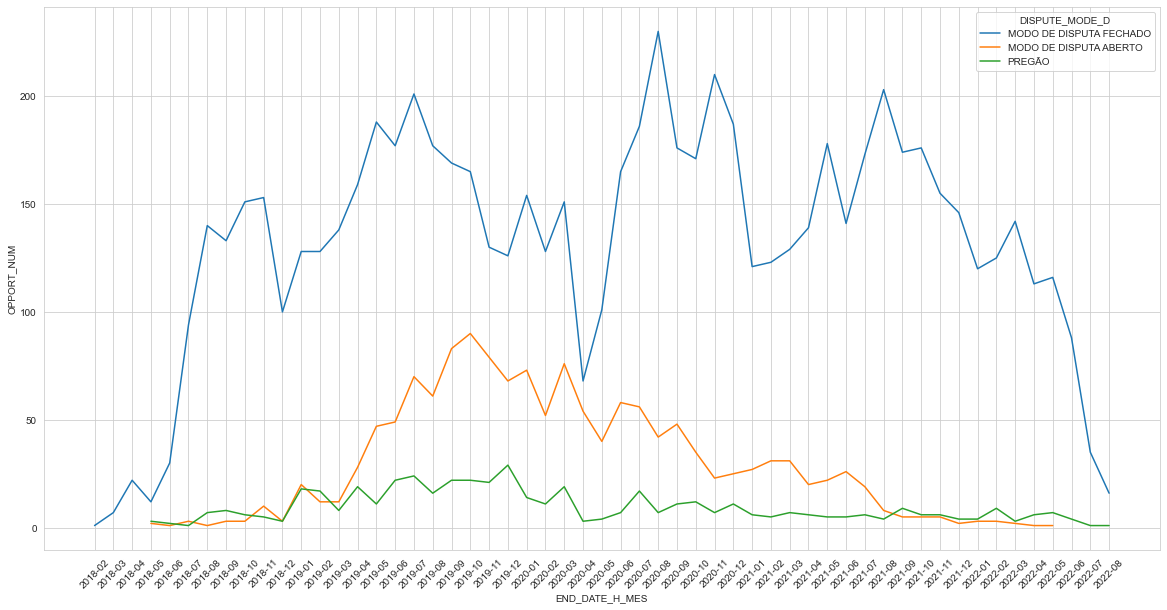

In [32]:
df_ano_mes_dispute = df.groupby(['END_DATE_H_MES','DISPUTE_MODE_D']).count()[['OPPORT_NUM']]
df_ano_mes_dispute.reset_index(inplace=True)
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=df_ano_mes_dispute, x=df_ano_mes_dispute['END_DATE_H_MES'].astype('str'), y=df_ano_mes_dispute['OPPORT_NUM'], ci=None, hue='DISPUTE_MODE_D')
ax.tick_params(axis='x', rotation=45)

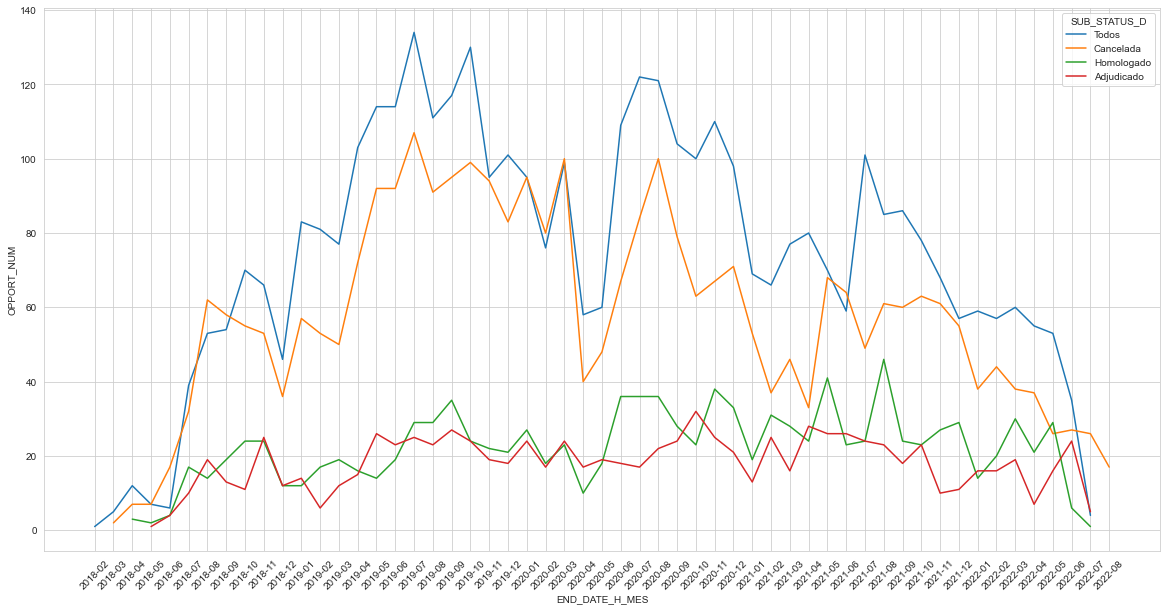

In [33]:
ano_mes_substatus = df.groupby(['END_DATE_H_MES','SUB_STATUS_D']).count()[['OPPORT_NUM']]
ano_mes_substatus.reset_index(inplace=True)
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=ano_mes_substatus, x=ano_mes_substatus['END_DATE_H_MES'].astype('str'), y=ano_mes_substatus['OPPORT_NUM'], ci=None, hue='SUB_STATUS_D')
ax.tick_params(axis='x', rotation=45)

In [34]:
df['DURACAO']= (df['END_DATE_H'].dt.date - df['START_DATE_H'].dt.date).dt.days
df['DURACAO'].describe().to_frame()
df[['OPPORT_NUM','END_DATE_H','START_DATE_H','DURACAO']].sort_values('DURACAO',ascending=False)
df_duracao = df[df['START_DATE_H']!='1900-01-01 00:00:00']
std = df_duracao['DURACAO'].describe().T.to_frame().loc['std'][0]

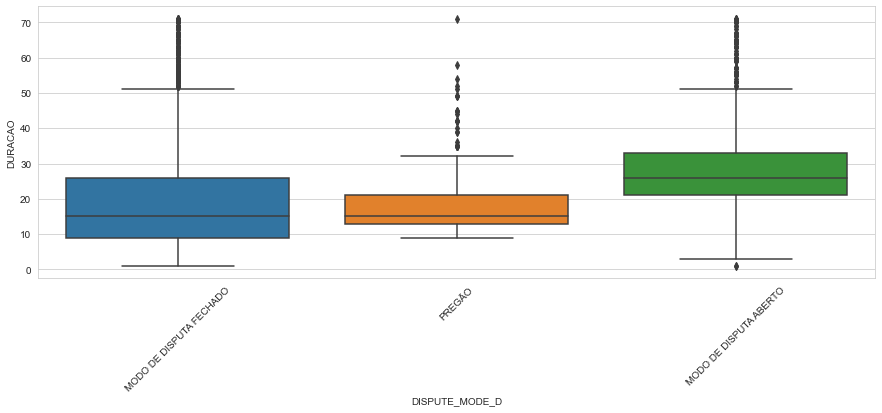

In [35]:
f, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y='DURACAO',x='DISPUTE_MODE_D',data=df_duracao[df_duracao['DURACAO']<std*3])
ax.tick_params(axis='x', rotation=45)

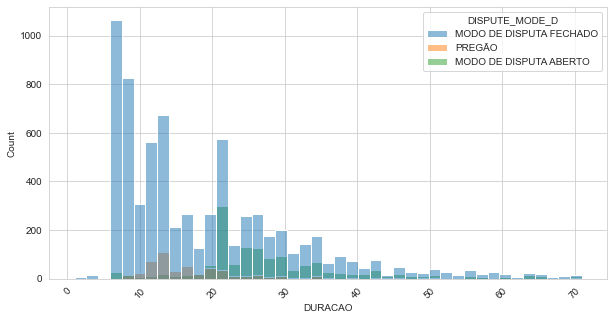

In [36]:
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(10,5))
sns.histplot(x='DURACAO',hue='DISPUTE_MODE_D', data=df_duracao[df_duracao['DURACAO']<std*3])
ax.tick_params(axis='x', rotation=45)

In [37]:
df.to_excel('Principal Unificado.xlsx')

In [38]:
df_cab = df

In [39]:
url = "https://github.com/kairobeduti/DadosShift/blob/master/Itens/Api_Itens.xlsx?raw=true"
data = rq.get(url).content
df_itens = pd.read_excel(BytesIO(data))
df_itens.drop(['Unnamed: 0','YPCOMT_LINE','ATTACHMENTS'],axis='columns',inplace=True)

In [40]:
df_itens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37381 entries, 0 to 37380
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SRC_GUID          37381 non-null  object 
 1   NUMBER_INT        37381 non-null  object 
 2   DESCRIPTION_UC    37364 non-null  object 
 3   ORDERED_PROD      28601 non-null  object 
 4   YPFAMITEM         32303 non-null  float64
 5   QUANTITY          37381 non-null  float64
 6   UNIT              36387 non-null  object 
 7   UNIT_TEXT         35098 non-null  object 
 8   DELIV_DATE        37381 non-null  object 
 9   EXLIN             37381 non-null  object 
 10  GROUPING_LEVEL    5083 non-null   object 
 11  ITEM_PROCESS_TYP  37361 non-null  object 
 12  LOTE              988 non-null    object 
 13  TOTAL             4095 non-null   object 
 14  OPPORT_NUM        37381 non-null  int64  
dtypes: float64(2), int64(1), object(12)
memory usage: 4.3+ MB


In [41]:
#dropar colunas que tem somente 1 registro para todo o dataset
lista_colunas_itens = df_itens.columns.to_list()
lista_valor_unico_remover_itens = []
for row in lista_colunas_itens:
  if len(df_itens[row].unique()) == 1:
    lista_valor_unico_remover_itens.append(row)
print(lista_valor_unico_remover_itens)
df_itens.drop(columns=lista_valor_unico_remover_itens,inplace=True)

[]


In [42]:
for lst_cols in lista_colunas_itens:
    if df_itens[lst_cols].value_counts().sum() != df_itens.shape[0]:
        df_itens[lst_cols].fillna('SEM '+lst_cols,inplace=True)

In [43]:
df_cab = df_cab.merge(df_itens, on='OPPORT_NUM')

In [44]:
url = "https://github.com/kairobeduti/DadosShift/blob/master/Hist%C3%B3rico/Historico_QUOTS.xlsx?raw=true"
data = rq.get(url).content
df_quots = pd.read_excel(BytesIO(data))
df_quots.drop(['Unnamed: 0'],axis='columns',inplace=True)

In [45]:
df_cab.to_excel('df_cab.xlsx')

In [46]:
df_geral = df_cab.merge(df_quots,on=['OPPORT_NUM','NUMBER_INT'])

<h2> checando colunas com sufixo _x e _y. Essas colunas são criadas automaticamente pelo pandas quando no merge elas tem o mesmo nome </br>
Abaixo são verificadas essas colunas, comparados os dados de ambas e se fore realmente identicas, deixa somente uma delas

In [51]:
lista_colunas_geral = df_geral.columns.to_list()
cols_duplicadas = []
for cols in lista_colunas_geral:
     if '_x' in cols or '_y' in cols:
         cols_duplicadas.append(cols.replace('_x','').replace('_y',''))
dict_colunas_repetidas = {}
for  cols_dpl in set(sorted(cols_duplicadas)):
    set_comparacao = set((df[cols_dpl+'_y'] == df[cols_dpl+'_x']).to_list())
    if len(set_comparacao) == 1 and list(set_comparacao)[0]:
        print(cols_dpl, '  ', set_comparacao)
        #df[cols_dpl] = df[cols_dpl+'_x']
        #print([cols_dpl+'_y',cols_dpl+'_x'])
        #df.drop([cols_dpl+'_y',cols_dpl+'_x'], axis='columns',inplace=True)

KeyError: 'DESCRIPTION_y'

In [50]:
#df_geral.to_excel('GERAL COM QUOTS.xlsx')